In [8]:
!pip install kaggle
!pip install scikeras

# Assuming you have your kaggle.json file uploaded to your Colab environment
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

!unzip coronahack-chest-xraydataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack

In [9]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


In [10]:

extracted_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
label_info_path = "Chest_xray_Corona_Metadata.csv"

# Check if the file exists at the given path
if os.path.exists(label_info_path):
    df = pd.read_csv(label_info_path)
    df.head()
else:
    print(f"Error: File not found at {label_info_path}")
    print("Please check if the dataset was correctly unzipped.")
    print("The unzipped folder should contain 'Chest_xray_Corona_Metadata.csv'")

In [4]:
df.isnull().sum()

,0
Unnamed: 0,0
X_ray_image_name,0
Label,0
Dataset_type,0
Label_2_Virus_category,5841
Label_1_Virus_category,1576


In [5]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [11]:
path_metadata = '../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv'
path_train = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
path_test = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
path_fasttext = '../input/fasttext-common-crawl-bin-model/cc.en.300.bin'
path_test_img = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/kjr-21-e24-g003-l-a.jpg'

In [12]:
# Create a copy of the original dataframe to preserve the original data
df1 = df.copy()

# Fill missing values in 'Label_1_Virus_category' with values from 'Label'
df1.Label_1_Virus_category.fillna(df1.Label, inplace=True)

# Fill missing values in 'Label_2_Virus_category' with values from 'Label_1_Virus_category'
df1.Label_2_Virus_category.fillna(df1.Label_1_Virus_category, inplace=True)

# Drop the original 'Label' and 'Label_1_Virus_category' columns as they are no longer needed
df1.drop(['Label', 'Label_1_Virus_category'], axis=1, inplace=True)

# Rename the columns for consistency and clarity
df1.rename(columns={'X_ray_image_name': 'Filename',
                    'Dataset_type': 'Type',
                    'Label_2_Virus_category': 'Class'}, inplace=True)

# Replace the 'Class' values to standardize the virus categories
df1.Class.replace({'Virus': 'viral pneumonia',
                   'bacteria': 'bacterial pneumonia',
                   'Normal': 'normal',
                   'COVID-19': 'covid-19'}, inplace=True)


In [8]:
df1.shape

(5910, 4)

In [9]:
df1['Class'].value_counts()

,count
Class,
bacterial pneumonia,2772
normal,1576
viral pneumonia,1493
covid-19,58
Streptococcus,5
SARS,4
ARDS,2


In [13]:
# dataframes (training, validation, testing)
df_train = df1[(df1.Type == 'TRAIN')]
df_test = df1[(df1.Type == 'TEST').reset_index(drop=True)]

# df_zsl = df[(df.Class.isin(class_zsl))].reset_index(drop=True)

In [11]:
df_train.head()

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal


In [14]:
df_train.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
# df_jsl.drop(['Type','Unnamed: 0'], axis=1, inplace=True)

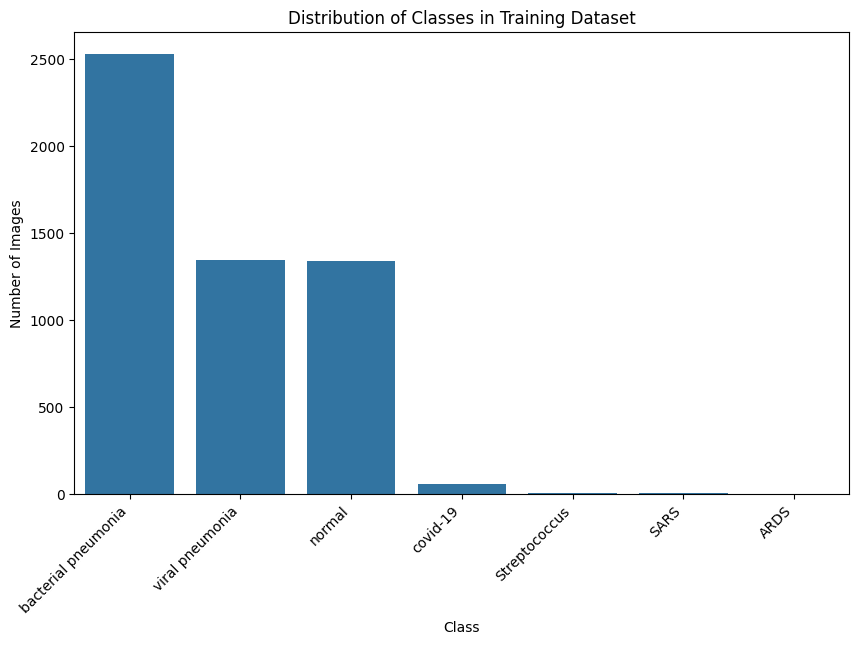

In [15]:


# Count the occurrences of each class
class_counts = df_train['Class'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [16]:
# prompt: select bacterial pneumonia,  viral pneumonia, normal from train dataset

import pandas as pd

# Assuming df_train is already defined from the previous code
selected_classes = ['bacterial pneumonia', 'viral pneumonia', 'normal']
df_train = df_train[df_train['Class'].isin(selected_classes)]

df_train

,Filename,Class
0,IM-0128-0001.jpeg,normal
1,IM-0127-0001.jpeg,normal
2,IM-0125-0001.jpeg,normal
3,IM-0122-0001.jpeg,normal
4,IM-0119-0001.jpeg,normal
...,...,...
5212,person88_virus_167.jpeg,viral pneumonia
5213,person88_virus_166.jpeg,viral pneumonia
5214,person88_virus_165.jpeg,viral pneumonia
5215,person88_virus_164.jpeg,viral pneumonia


In [17]:
X_train = df_train['Filename']
y_train = df_train['Class']
X_test = df_test['Filename']
y_test = df_test['Class']

In [18]:
# Create an ImageDataGenerator for training data with preprocessing and augmentation
idg_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,  # Preprocess input images using Xception's preprocessing function
    zoom_range=0.1,  # Apply random zoom augmentation within a range of 10%
    brightness_range=[0.5, 1.3],  # Randomly adjust brightness between 50% and 130%
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1  # Randomly shift images vertically by up to 10% of the height
)

# Create an ImageDataGenerator for test data with only preprocessing
idg_test = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input  # Preprocess input images using Xception's preprocessing function
)

# Generate augmented training data from a dataframe
data_train = idg_train.flow_from_dataframe(
    dataframe=df_train,  # Dataframe containing training data information
    directory=path_train,  # Directory where training images are stored
    x_col='Filename',  # Column name in dataframe for image filenames
    y_col='Class',  # Column name in dataframe for image labels
    target_size=(224, 224),  # Resize images to 224x224 (input size for Xception model)
    batch_size=64,  # Number of images per batch
    shuffle=True,  # Shuffle the data to ensure randomness
    class_mode='categorical'  # Labels are in categorical format (one-hot encoding)
)

# Generate test data from a dataframe
data_test = idg_test.flow_from_dataframe(
    dataframe=df_test,  # Dataframe containing test data information
    directory=path_test,  # Directory where test images are stored
    x_col='Filename',  # Column name in dataframe for image filenames
    y_col='Class',  # Column name in dataframe for image labels
    target_size=(224, 224),  # Resize images to 224x224 (input size for Xception model)
    batch_size=64,  # Number of images per batch
    shuffle=True,  # Shuffle the data to ensure randomness
    class_mode='categorical'  # Labels are in categorical format (one-hot encoding)
)


Found 5217 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [19]:
# Import train_test_split from sklearn to split the dataset
from sklearn.model_selection import train_test_split

# Split the training dataframe into training and validation sets
# X_train_split and X_val_split contain the 'Filename' column (input features)
# y_train_split and y_val_split contain the 'Class' column (target labels)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    df_train['Filename'],  # Input feature: image filenames
    df_train['Class'],  # Target labels: classes
    test_size=0.2,  # Proportion of data to use for validation (20%)
    random_state=42  # Random seed for reproducibility
)

# Create a new dataframe for the training split
df_train_split = pd.DataFrame({
    'Filename': X_train_split,  # Training image filenames
    'Class': y_train_split  # Corresponding training labels
})

# Create a new dataframe for the validation split
df_val_split = pd.DataFrame({
    'Filename': X_val_split,  # Validation image filenames
    'Class': y_val_split  # Corresponding validation labels
})

# Generate augmented training data for the split training set
data_train_split = idg_train.flow_from_dataframe(
    dataframe=df_train_split,  # Dataframe for the training split
    directory=path_train,  # Directory where training images are stored
    x_col='Filename',  # Column name for image filenames
    y_col='Class',  # Column name for image labels
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=64,  # Number of images per batch
    class_mode='categorical'  # Labels are in categorical format (one-hot encoding)
)

# Generate validation data from the split validation set
data_val_split = idg_test.flow_from_dataframe(
    dataframe=df_val_split,  # Dataframe for the validation split
    directory=path_train,  # Directory where training images are stored (same as train set directory)
    x_col='Filename',  # Column name for image filenames
    y_col='Class',  # Column name for image labels
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=64,  # Number of images per batch
    class_mode='categorical'  # Labels are in categorical format (one-hot encoding)
)


Found 4173 validated image filenames belonging to 3 classes.
Found 1044 validated image filenames belonging to 3 classes.


In [20]:
# prompt: check how many images are in the train and val

print("Number of images in the training set:", len(df_train_split))
print("Number of images in the validation set:", len(df_val_split))

Number of images in the training set: 4173
Number of images in the validation set: 1044


In [21]:
data_val_split.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

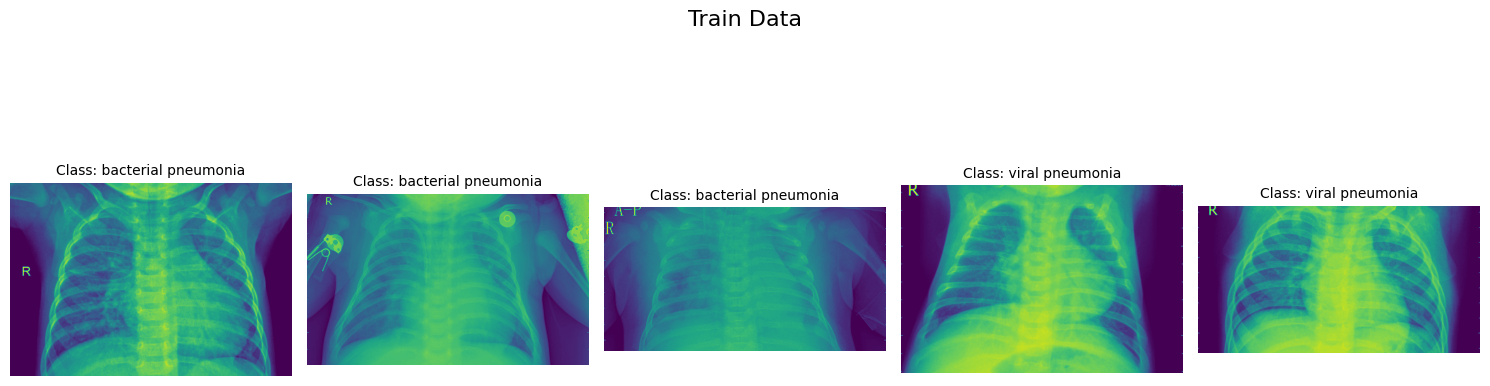

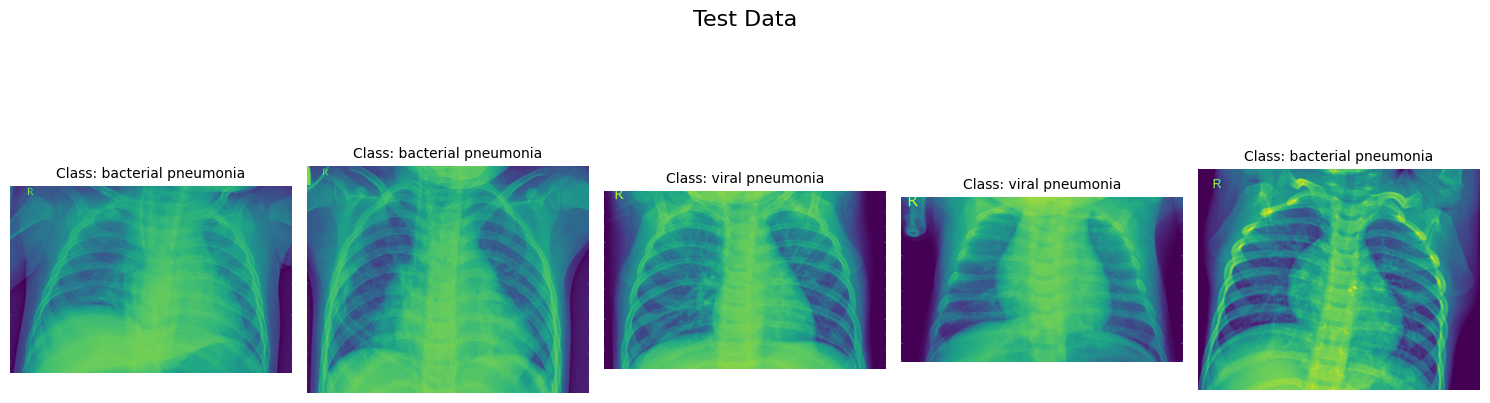

In [22]:
import os  # For file and path operations
import random  # For random sampling
import matplotlib.pyplot as plt  # For displaying images

# Function to display images in a row from a given dataframe and path
def display_images_in_row(df, path, title, num_images=5):
    """
    Display a row of images with their corresponding class labels.

    Args:
    - df: DataFrame containing image filenames and labels
    - path: Directory where images are stored
    - title: Title of the plot
    - num_images: Number of images to display (default is 5)
    """
    # Select random rows from the DataFrame
    random_indices = random.sample(range(len(df)), num_images)  # Randomly pick `num_images` indices
    selected_rows = df.iloc[random_indices]  # Select rows based on the random indices

    # Create a subplot for displaying the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # 1 row and `num_images` columns
    fig.suptitle(title, fontsize=16)  # Set the title of the plot

    # Loop through the selected indices to display images
    for i, idx in enumerate(random_indices):
        filename = selected_rows.iloc[i]['Filename']  # Get the image filename
        class_label = selected_rows.iloc[i]['Class']  # Get the class label

        # Construct the full path to the image
        image_path = os.path.join(path, filename)

        try:
            # Load and display the image
            img = plt.imread(image_path)
            axes[i].imshow(img)  # Display the image
            axes[i].set_title(f"Class: {class_label}", fontsize=10)  # Set the title with the class label
            axes[i].axis('off')  # Hide the axes for a cleaner look
        except FileNotFoundError:
            # Handle missing files by displaying an error message
            axes[i].text(0.5, 0.5, 'File not found', ha='center', va='center', fontsize=8)
            axes[i].axis('off')  # Hide the axes

    # Adjust layout to fit the title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()  # Display the plot

# Example usage for the training dataset
display_images_in_row(df_train, path_train, title="Train Data", num_images=5)  # Display 5 random training images
print()  # Print a blank line for separation

# Example usage for the testing dataset
display_images_in_row(df_test, path_test, title="Test Data", num_images=5)  # Display 5 random testing images


In [23]:
data_train.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [25]:
# Define directory and filename for saving the best model
model_dir = 'models'  # Directory to store the saved models
model_file = 'best_xception.keras'  # File name for the best model

# Create the model directory if it doesn't already exist
if not os.path.exists(model_dir):
    os.mkdir(model_dir)  # Create a directory named 'models'

# Set up a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    os.path.join(model_dir, model_file),  # Full path to save the best model
    monitor='val_loss',  # Metric to monitor for improvement
    verbose=1,  # Print messages when the model is saved
    save_best_only=True,  # Save only the best model based on the monitored metric
    save_weights_only=False  # Save the entire model, not just weights
)

# Set up an EarlyStopping callback to stop training if no improvement
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for stopping
    patience=30,  # Number of epochs with no improvement to wait before stopping
    verbose=1,  # Print messages when stopping
    restore_best_weights=True  # Restore the model weights from the best epoch
)


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Xception

In [26]:
# Define the input layer for the model
inputs = tf.keras.layers.Input((224, 224, 3))  # Input shape for 224x224 RGB images

# Load the Xception base model with pre-trained weights
base_model = Xception(
    include_top=False,  # Exclude the top (fully connected) layers
    weights="imagenet",  # Use weights pre-trained on the ImageNet dataset
    input_shape=(224, 224, 3),  # Input shape for the base model
    pooling='avg'  # Apply global average pooling to the output of the base model
)

# Pass the input through the base model
x = base_model(inputs)

# Add a dense layer for the output
output = layers.Dense(3, activation='sigmoid')(x)  # Output layer with 3 nodes (binary cross-entropy)

# Create the complete model
model_xception = tf.keras.models.Model(inputs=inputs, outputs=output)

# Compile the model with Adamax optimizer, binary cross-entropy loss, and accuracy metric
model_xception.compile(
    Adamax(learning_rate=1e-4),  # Optimizer with a learning rate of 0.0001
    loss='binary_crossentropy',  # Loss function for multi-label classification
    metrics=['accuracy']  # Evaluation metric
)

# Print the summary of the model architecture
model_xception.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
# Define callbacks for training

# Record the start time for training
training_time_start = datetime.datetime.now()

# Train the model
history_xception = model_xception.fit(
    data_train_split,  # Training data generator
    epochs=30,  # Number of epochs to train
    validation_data=data_val_split,  # Validation data generator
    callbacks=[checkpoint, early_stopping]  # Callbacks for model checkpointing and early stopping
)

# Record the end time for training
training_time_end = datetime.datetime.now()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6825 - loss: 0.5263
Epoch 1: val_loss improved from inf to 0.41671, saving model to models/best_xception.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.6834 - loss: 0.5249 - val_accuracy: 0.7471 - val_loss: 0.4167
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8068 - loss: 0.3075
Epoch 2: val_loss improved from 0.41671 to 0.37237, saving model to models/best_xception.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8069 - loss: 0.3073 - val_accuracy: 0.7222 - val_loss: 0.3724
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8205 - loss: 0.2745
Epoch 3: val_loss improved from 0.37237 to 0.33247, saving model to models/best_xception.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8205 - loss: 0.2745 - val_accuracy: 0.7644 - val_loss: 0.3325
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8375 - loss: 0.2534
Epoch 4: val_loss improved from 0.33247 t

In [ ]:
# Calculate the total training time in seconds
total_training_seconds = (training_time_end - training_time_start).seconds

# Convert the training time to a human-readable format and print
print('Total training time: ', str(datetime.timedelta(seconds=total_training_seconds)))


Total training time:  0:47:36


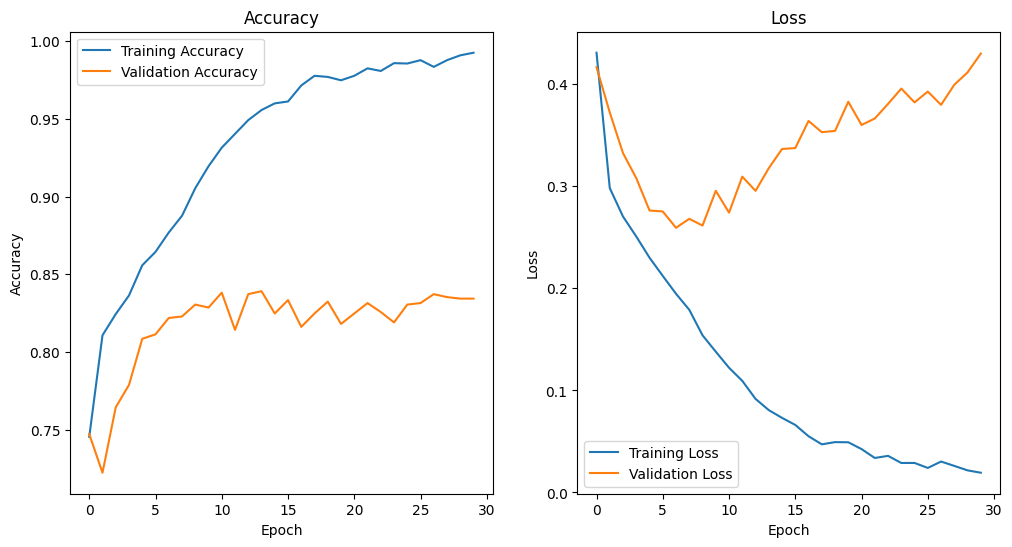

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'], label='Training Accuracy')  # Training accuracy
plt.plot(history_xception.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
plt.title('Accuracy')  # Title for accuracy plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Add legend to differentiate training and validation

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'], label='Training Loss')  # Training loss
plt.plot(history_xception.history['val_loss'], label='Validation Loss')  # Validation loss
plt.title('Loss')  # Title for loss plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Add legend to differentiate training and validation

# Display the plots
plt.show()


In [ ]:
data_train

17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 601ms/step
Accuracy: 0.38122606
Precision: 0.3424444596402736
Recall: 0.3444943626922406
F1-score: 0.3423820332769247

Confusion Matrix:
 [[250 147 106]
 [136 101  51]
 [140  66  47]]


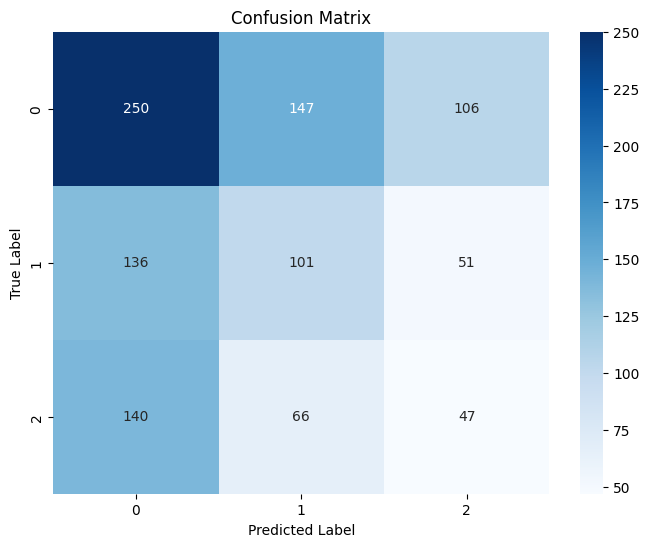

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the validation set
# Get raw predictions using model.predict
predictions_raw = model_xception.predict(data_val_split)

# Convert raw predictions to class labels using argmax
predictions = tf.math.argmax(predictions_raw, axis=1).numpy()

# True class labels from the validation data
y_true = data_val_split.classes

# Calculate accuracy using tf.keras.metrics.Accuracy
accuracy_metric = tf.keras.metrics.Accuracy()  # Create an Accuracy metric instance
accuracy_metric.update_state(y_true, predictions)  # Update the metric with true and predicted values
accuracy = accuracy_metric.result().numpy()  # Get the computed accuracy
print('Accuracy:', accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, predictions, average='macro')  # Precision across classes
recall = recall_score(y_true, predictions, average='macro')  # Recall across classes
f1 = f1_score(y_true, predictions, average='macro')  # F1-score across classes

# Print precision, recall, and F1-score
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, predictions)

# Print the confusion matrix
print('\nConfusion Matrix:\n', cm)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # Display the matrix as a heatmap
plt.xlabel('Predicted Label')  # X-axis label
plt.ylabel('True Label')  # Y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Show the plot


In [ ]:
# model_path = os.path.join(model_dir, "best_xception.h5")

In [ ]:
# model_xception.save(model_path)

In [ ]:
# Load the saved model
x_model = keras.models.load_model("models/best_xception.keras")

In [ ]:
 test_loss, test_acc = x_model.evaluate(data_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8501 - loss: 0.2678


In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.2652
Test Accuracy: 0.8558


In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.2 MB/s eta 0:00:00


## hypeparameter tunning

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam, AdamW, Adamax, AdamW
import kerastuner as kt


def build_model(hp):
    try:
        model = Sequential()
        model.add(
            Xception(
                weights="imagenet",
                include_top=False,
                input_shape=(224, 224, 3),
            )
        )
        model.add(Flatten())
        model.add(
            Dense(
                hp.Int("units", min_value=32, max_value=128, step=32),
                activation="relu",
            )
        )
        model.add(Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(3, activation="sigmoid"))

        model.compile(
            optimizer=Adam(
                hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
            ),
            loss="binary_crossentropy",
            metrics=["accuracy"],
        )
        return model
    except Exception as e:
        print(f"Error in build_model: {e}")  # Print the error message
        raise  # Re-raise the exception to stop the search

tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="my_dir",
    project_name="xception_tuner",
)

tuner.search(data_train_split, validation_data=data_val_split)

best_model = tuner.get_best_models(num_models=1)[0]


Trial 24 Complete [00h 16m 10s]
val_accuracy: 0.8496168851852417

Best val_accuracy So Far: 0.8496168851852417
Total elapsed time: 01h 41m 04s


In [ ]:
# Save the best model
best_model.save("tunner_xception_model.h5")

In [ ]:
# # Extract relevant data
# results = grid_result.cv_results_
# params = results['params']
# mean_test_score = results['mean_test_score']

# # Create a DataFrame
# df = pd.DataFrame(params)
# df['mean_test_score'] = mean_test_score

# # Plot a heatmap
# sns.heatmap(df.pivot_table(index='param_1', columns='param_2', values='mean_test_score'), annot=True)
# plt.title('Heatmap of Mean Test Score')
# plt.xlabel('Parameter 1')
# plt.ylabel('Parameter 2')
# plt.show()

# # Plot a line plot
# sns.lineplot(x='param_1', y='mean_test_score', data=df, hue='param_2')
# plt.title('Line Plot of Mean Test Score')
# plt.xlabel('Parameter 1')
# plt.ylabel('Mean Test Score')
# plt.show()